# Generating 3D People in Scenes without People

Here we give a frontend demo of how to generate body meshes in a scene without people. 
+ First, we use a pre-trained conditional VAE model to generate body meshes. Here we only show the one-stage model without scene loss. 
+ Second, we perform scene geometry-aware fitting.

The code in this demo is slightly different from the code in other places. __To efficiently generate a large amount of body meshes for various scenes, we recommend to use the frontend sh scripts.__

## (1) loading dependencies, models and setup environments

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division


import sys, os, glob
import json
import argparse
import numpy as np
import scipy.io as sio

import open3d as o3d
from pyntcloud import PyntCloud


# proj_path = '/is/ps2/yzhang/workspaces/PSI-internal'
proj_path = '/home/ryeon/project/psi'
sys.path.append(proj_path)
sys.path.append(proj_path+'/source')


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
from torch.optim import lr_scheduler

import smplx
from human_body_prior.tools.model_loader import load_vposer

from cvae import HumanCVAES1, HumanCVAES2, ContinousRotReprDecoder

import time


In [2]:
import smplx
from human_body_prior.tools.model_loader import load_vposer
import chamfer_pytorch.dist_chamfer as ext


We put some auxilary functions here, mainly for coordinate transform and file parsing.

In [3]:
def recover_global_T(x_batch, cam_intrisic, max_depth):
    xt_batch = x_batch[:,:3]
    xr_batch = x_batch[:,3:]

    fx_batch = cam_intrisic[:,0,0]
    fy_batch = cam_intrisic[:,1,1]
    px_batch = cam_intrisic[:,0,2]
    py_batch = cam_intrisic[:,1,2]
    s_ = 1.0 / torch.max(px_batch, py_batch)

    z = (xt_batch[:, 2]+1.0)/2.0 * max_depth

    x = xt_batch[:,0] * z / s_ / fx_batch
    y = xt_batch[:,1] * z / s_ / fy_batch
    
    xt_batch_recoverd = torch.stack([x,y,z],dim=-1)

    return torch.cat([xt_batch_recoverd, xr_batch],dim=-1)



def convert_to_3D_rot(x_batch):
    xt = x_batch[:,:3]
    xr = x_batch[:,3:9]
    xb = x_batch[:,9:]

    xr_mat = ContinousRotReprDecoder.decode(xr) # return [:,3,3]
    xr_aa = ContinousRotReprDecoder.matrot2aa(xr_mat) # return [:,3]

    return torch.cat([xt, xr_aa, xb], dim=-1)


def body_params_encapsulate(x_body_rec, to_numpy=True, batched=False):
    
    if to_numpy:
        x_body_rec_np = x_body_rec.detach().cpu().numpy()
    else:
        x_body_rec_np = x_body_rec
        
    
    if batched:
        body_params_batch_rec={}
        body_params_batch_rec['transl'] = x_body_rec_np[:,:3]
        body_params_batch_rec['global_orient'] = x_body_rec_np[:,3:6]
        body_params_batch_rec['betas'] = x_body_rec_np[:,6:16]
        body_params_batch_rec['body_pose'] = x_body_rec_np[:,16:48]
        body_params_batch_rec['left_hand_pose'] = x_body_rec_np[:,48:60]
        body_params_batch_rec['right_hand_pose'] = x_body_rec_np[:,60:]
        
        return body_params_batch_rec
    
    else:
        n_batch = x_body_rec_np.shape[0]
        rec_list = []

        for b in range(n_batch):
            body_params_batch_rec={}
            body_params_batch_rec['transl'] = x_body_rec_np[b:b+1,:3]
            body_params_batch_rec['global_orient'] = x_body_rec_np[b:b+1,3:6]
            body_params_batch_rec['betas'] = x_body_rec_np[b:b+1,6:16]
            body_params_batch_rec['body_pose'] = x_body_rec_np[b:b+1,16:48]
            body_params_batch_rec['left_hand_pose'] = x_body_rec_np[b:b+1,48:60]
            body_params_batch_rec['right_hand_pose'] = x_body_rec_np[b:b+1,60:]
            rec_list.append(body_params_batch_rec)

        return rec_list




def data_preprocessing(img, modality, target_domain_size=[128, 128]):

    """
    input:
        - img (depthmap or semantic map): [height, width].
        - modality: 'depth' or 'seg'
    output:
        canvas: with shape of target_domain_size, where the input is in the
                center tightly, with shape target_domain_size
        factor: the resizing factor
    """

    # prepare the canvas
    img_shape_o = img.shape
    canvas = torch.zeros([1,1]+target_domain_size, dtype=torch.float32,
                         device=torch.device("cuda"))


    # filter out unavailable values
    if modality == 'depth':
        img[img>6.0]=6.0

    if modality == 'seg':
        img[img>41] = 41



    ## rescale to [-1,1]
    max_val = torch.max(img)
    _img = 2* img / max_val - 1.0

    ## put _img to the canvas
    if img_shape_o[0]>= img_shape_o[1]:
        factor = float(target_domain_size[0]) / img_shape_o[0]
        target_height = target_domain_size[0]
        target_width = int(img_shape_o[1] * factor) //2 *2 

        # for depth map we use bilinear interpolation in resizing
        # for segmentation map we use bilinear interpolation as well.
        # note that float semantic label is not real in practice, but
        # helpful in our work
        target_size = [target_height, target_width]

        _img = _img.view(1,1,img_shape_o[0],img_shape_o[1])
        img_resize = F.interpolate(_img, size=target_size, mode='bilinear',
                                    align_corners=False)

        na = target_width
        nb = target_domain_size[1]
        lower = (nb //2) - (na //2)
        upper = (nb //2) + (na //2)

        canvas[:,:,:, lower:upper] = img_resize


    else:
        factor = float(target_domain_size[1]) / img_shape_o[1]

        target_height = int(factor*img_shape_o[0]) //2 *2
        target_width = target_domain_size[1]

        target_size = [target_height, target_width]
        _img = _img.view(1,1,img_shape_o[0],img_shape_o[1])
        img_resize = F.interpolate(_img, size=target_size, mode='bilinear',
                                    align_corners=False)

        na = target_height
        nb = target_domain_size[0]
        lower = (nb //2) - (na //2)
        upper = (nb //2) + (na //2)

        canvas[:,:,lower:upper, :] = img_resize

    return canvas, factor, max_val




def scipy_matfile_parse(filename):
    '''
    parse data from files and put them to GPU
    Note that this function is for demo, and is different from the ones used in other places.
    '''
    data = sio.loadmat(filename)
    depth0_np = data['depth']
    seg0_np = data['seg']

    ## change them to torch tensor
    depth0 = torch.tensor(depth0_np, dtype=torch.float32, device=torch.device("cuda"))
    seg0 = torch.tensor(seg0_np, dtype=torch.float32, device=torch.device("cuda"))

    ## pre_processing
    depth, factor_d,max_d = data_preprocessing(depth0, 'depth', target_domain_size=[128, 128])
    seg, factor_s,_ = data_preprocessing(seg0, 'seg', target_domain_size=[128, 128])


    cam_intrinsic_np = data['cam'][0][0]['intrinsic']
    cam_intrinsic = torch.tensor(cam_intrinsic_np, dtype=torch.float32, device=torch.device("cuda")).unsqueeze(0)
    cam_extrinsic_np = data['cam'][0][0]['extrinsic']
    cam_extrinsic_np = np.linalg.inv(cam_extrinsic_np)
    cam_extrinsic = torch.tensor(cam_extrinsic_np, dtype=torch.float32, device=torch.device("cuda")).unsqueeze(0)

    return depth, seg, max_d.view(1), cam_intrinsic, cam_extrinsic



## (2) Prepare the scene without people

Our method requires the following data about a scene:
+ depth map
+ semantic segmentation
+ the camera parameters (extrinsic and intrinsic)
+ the scene signed distance function (SDF)
+ the scene mesh

Note that SDF and scene mesh are only used for scene-geometry aware fitting. For generating body meshes with the CVAE model, only the first three attributes are sufficient.

Here we use the 'MPH16' scene in the __PROXE__ dataset.

In [4]:
scenename = 'MPH16'
proxe_path = '/data/proxe'

## read the depth and semantics
scene_matfile_path = os.path.join(proxe_path, 'snapshot_for_testing/MPH16_00157_01/rec_000000.mat')
depth, seg, max_d, cam_intrinsic, cam_extrinsic = scipy_matfile_parse(scene_matfile_path)

## read the sdf
with open(os.path.join(proxe_path, 'scenes_sdf',scenename+'.json')) as f:
    sdf_data = json.load(f)
    grid_min = np.array(sdf_data['min'])
    grid_max = np.array(sdf_data['max'])
    grid_dim = sdf_data['dim']
sdf = np.load(os.path.join(proxe_path, 'scenes_sdf', scenename + '_sdf.npy')).reshape(grid_dim, grid_dim, grid_dim)

## read the scene mesh
scene_mesh = o3d.io.read_triangle_mesh(os.path.join(proxe_path, 'scenes_downsampled', scenename+'.ply'))
scene_verts = np.asarray(scene_mesh.vertices)
scene_faces = np.asarray(scene_mesh.triangles)
scene_pcd = PyntCloud.from_instance("open3d", scene_mesh)



/home/ryeon/anaconda3/envs/psi/lib/python3.6/site-packages/pythreejs/traits.py:203: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.38396479610201845, 2.714185747882214, 2.2…

Preview(child=Scene(children=(Points(geometry=BufferGeometry(attributes={'position': <BufferAttribute shape=(5…

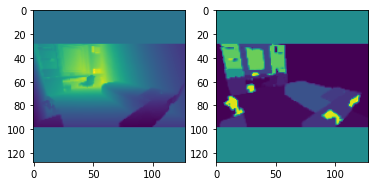

In [5]:
## We could visualize the scene data, or skip this step.

import matplotlib.pyplot as plt

plt.subplot(1,2,1)
depth_processed_np = depth.detach().cpu().squeeze().numpy()
plt.imshow(depth_processed_np)

plt.subplot(1,2,2)
seg_processed_np = seg.detach().cpu().squeeze().numpy()
plt.imshow(seg_processed_np)

# we use webGL to visualize 3D, which is a different case from running locally.
# only works for point cloud visualization
# note that visualizing 3D here may cause slow responses.
pcd = o3d.geometry.PointCloud()
pcd.points = scene_mesh.vertices
pcd.colors = scene_mesh.vertex_colors

scene_pcd.plot(backend='pythreejs', return_scene=True)

# from open3d import JVisualizer
# visualizer = JVisualizer()
# visualizer.add_geometry(pcd)
# visualizer.show()


## （3） Generating body meshes using the pre-trained conditional VAE model

For demonstration purposes, we only use the **one-stage model without scene loss**. For other models, the pipeline is the same.

In [6]:
testconfig={
    'smplx_model_path': '/data/smpl_models',
    'scene_model_ckpt': '/home/ryeon/project/psi/data/resnet18.pth',
    'vposer_ckpt_path': '/data/smpl_models/vposer_v1_0',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'ckpt_dir': 'checkpoints_v2/checkpoints_proxtrain_models1_batch32_epoch30_LR0.0003_LossVposer0.001_LossKL0.1_LossContact0.000001_LossCollision0.000001',
    'n_samples': 2
}

### our conditional vae model
model_h = HumanCVAES1(latentD=256, # default value in our checkpoints
                      n_dim_body=75,# global T(3d) + global R(6d) + shape (10d) + pose (32d) + hand (24d)
                      scene_model_ckpt=None,
                      test=True)

# model_h = HumanCVAES2(latentD_g=256, # default value in our checkpoints
#                       latentD_l=256, # default value in our checkpoints
#                       n_dim_body=75,# global T(3d) + global R(6d) + shape (10d) + pose (32d) + hand (24d)
#                       scene_model_ckpt=None,
#                       test=True)

### VPoesr
vposer, _ = load_vposer(testconfig['vposer_ckpt_path'], vp_model='snapshot')

### smplx
body_mesh_model = smplx.create(testconfig['smplx_model_path'], 
                               model_type='smplx',
                               gender='neutral', ext='npz',
                               num_pca_comps=12,
                               create_global_orient=True,
                               create_body_pose=True,
                               create_betas=True,
                               create_left_hand_pose=True,
                               create_right_hand_pose=True,
                               create_expression=True,
                               create_jaw_pose=True,
                               create_leye_pose=True,
                               create_reye_pose=True,
                               create_transl=True,
                               batch_size=testconfig['n_samples']
                               )

## setup models and load checkpoints
model_h.eval()
model_h.to(testconfig['device'])

vposer.to(testconfig['device'])
body_mesh_model.to(testconfig['device'])

ckp_path = sorted(glob.glob(os.path.join(testconfig['ckpt_dir'],'epoch-*.ckp')),
                    key=os.path.getmtime)[-1]


checkpoint = torch.load(ckp_path)
print('[INFO] load checkpoints: ' + ckp_path)

model_h.load_state_dict(checkpoint['model_h_state_dict'])



Found Trained Model: /data/smpl_models/vposer_v1_0/snapshots/TR00_E096.pt
[INFO] load checkpoints: checkpoints_v2/checkpoints_proxtrain_models1_batch32_epoch30_LR0.0003_LossVposer0.001_LossKL0.1_LossContact0.000001_LossCollision0.000001/epoch-000030.ckp


<All keys matched successfully>

Run the following code block to sample body configurations.

In [7]:
## generating body configurations

### concatenate depth and seg
xs = torch.cat([depth, seg],dim=1)
xs_n = xs.repeat(testconfig['n_samples'], 1,1,1)

### model inference
xhnr_gen= model_h.sample(xs_n)

### recover to the original translation/orientation range 
xhn_gen = convert_to_3D_rot(xhnr_gen)        
xh_gen = recover_global_T(xhn_gen, cam_intrinsic.repeat(testconfig['n_samples'],1,1), 
                          max_d.repeat(testconfig['n_samples']))



In the following, we visualize the generated body configurations.

In [8]:
## visualizing a body mesh. Note that we use WebGL, which may cause slow responses or even stuck.

body_params = body_params_encapsulate(xh_gen, to_numpy=False, batched=True)
body_params['body_pose'] = vposer.decode(body_params['body_pose'], output_type='aa').view(testconfig['n_samples'],-1)

smplx_out = body_mesh_model(**body_params)
smplx_verts = smplx_out.vertices.detach().cpu().numpy().squeeze()    

cam_ext = cam_extrinsic.squeeze().detach().cpu().numpy()

### create a body point cloud
pcd_body_list = []
for body_index in range(testconfig['n_samples']):
    # body_index = 20
    pcd_body = o3d.geometry.PointCloud()
    pcd_body.points = o3d.utility.Vector3dVector(smplx_verts[body_index])
    pcd_body = pcd_body.uniform_down_sample(every_k_points=2)
    
    ### perform transformation
    pcd_body.transform(cam_ext)
    pcd_body_list.append(pcd_body)
    
    

### create a scene point cloud
pcd_scene = o3d.geometry.PointCloud()
pcd_scene.points = scene_mesh.vertices
pcd_scene.colors = scene_mesh.vertex_colors
pcd_scene = pcd_scene.uniform_down_sample(every_k_points=10)

### create coord frame
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=0.6, origin=[0, 0, 0])

pcd_coord = o3d.geometry.PointCloud()
pcd_coord.points = mesh_frame.vertices
pcd_coord.colors = mesh_frame.vertex_colors
pcd_coord.transform(cam_ext)

#Visualize
scene_pcd = PyntCloud.from_instance("open3d", scene_mesh)
tot_scene_pcd = scene_pcd.plot(backend='pythreejs', initial_point_size=0.1,  return_scene=True)

import random
colors = [157, 158, 204]

for body_index in range(testconfig['n_samples']):
    body_pcd = PyntCloud.from_instance("open3d", pcd_body_list[body_index])
    body_pcd.points["red"] = random.choice(colors)
    body_pcd.points["blue"] = random.choice(colors)
    body_pcd.points["green"] = random.choice(colors)
    body_pcd.plot(backend='pythreejs', initial_point_size=0.03, scene=tot_scene_pcd)

    
# ### visualize in WebGL
# from open3d import JVisualizer
# visualizer = JVisualizer()
# visualizer.add_geometry(pcd_scene)
# visualizer.add_geometry(pcd_coord)
# for body_index in range(testconfig['n_samples']):
#     visualizer.add_geometry(pcd_body_list[body_index])

# visualizer.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.38396479610201845, 2.714185747882214, 2.2…

### (4) scene geometry-aware fitting

One see that some generated body meshes are not physically plausible, either floating in the air or penetrating into the scene mesh. Therefore, we have this geometry-aware fitting to overcome these problems. 


In [9]:
import torch.optim as optim
from torch.autograd import Variable
import chamfer_pytorch.dist_chamfer as ext


def get_contact_id(body_segments_folder, contact_body_parts=['L_Hand', 'R_Hand']):

    contact_verts_ids = []
    contact_faces_ids = []

    for part in contact_body_parts:
        with open(os.path.join(body_segments_folder, part + '.json'), 'r') as f:
            data = json.load(f)
            contact_verts_ids.append(list(set(data["verts_ind"])))
            contact_faces_ids.append(list(set(data["faces_ind"])))

    contact_verts_ids = np.concatenate(contact_verts_ids)
    contact_faces_ids = np.concatenate(contact_faces_ids)


    return contact_verts_ids, contact_faces_ids

    
    

def verts_transform(verts_batch, cam_ext_batch):
    verts_batch_homo = F.pad(verts_batch, (0,1), mode='constant', value=1)
    verts_batch_homo_transformed = torch.matmul(verts_batch_homo,
                                                cam_ext_batch.permute(0,2,1))

    verts_batch_transformed = verts_batch_homo_transformed[:,:,:-1]
    
    return verts_batch_transformed    
    
    


def cal_loss(xhr, xhr_rec, cam_ext_batch, s_verts_batch,
             s_sdf_batch,s_grid_min_batch, s_grid_max_batch,
             lossconfig, fittingconfig):


    ### reconstruction loss
    loss_rec = lossconfig['weight_loss_rec']*F.l1_loss(xhr, xhr_rec)
    xh_rec = convert_to_3D_rot(xhr_rec)

    ### vposer loss
    vposer_pose = xh_rec[:,16:48]
    loss_vposer = lossconfig['weight_loss_vposer'] * torch.mean(vposer_pose**2)

    ### contact loss
    body_param_rec = body_params_encapsulate(xh_rec, to_numpy=False, batched=True)
    body_param_rec['body_pose'] = vposer.decode(body_param_rec['body_pose'], 
                                       output_type='aa').view(xhr.shape[0], -1)

    smplx_output = body_mesh_model(return_verts=True, **body_param_rec)
    body_verts_batch = smplx_output.vertices #[b, 10475,3]
    body_verts_batch = verts_transform(body_verts_batch, cam_ext_batch)

    
    vid, fid = get_contact_id(body_segments_folder=fittingconfig['body_segments_folder'],
                              contact_body_parts=fittingconfig['contact_part'])
    
    body_verts_contact_batch = body_verts_batch[:, vid, :]

    dist_chamfer_contact = ext.chamferDist()
    contact_dist, _ = dist_chamfer_contact(body_verts_contact_batch.contiguous(), 
                                            s_verts_batch.contiguous())

    loss_contact = lossconfig['weight_contact'] * torch.mean(torch.sqrt(contact_dist+1e-4)
                                                            /(torch.sqrt(contact_dist+1e-4)+0.01))  



    ### sdf collision loss
    s_grid_min_batch = s_grid_min_batch.unsqueeze(1)
    s_grid_max_batch = s_grid_max_batch.unsqueeze(1)

    norm_verts_batch = (body_verts_batch - s_grid_min_batch) / (s_grid_max_batch - s_grid_min_batch) *2 -1
    n_verts = norm_verts_batch.shape[1]
    body_sdf_batch = F.grid_sample(s_sdf_batch.unsqueeze(1), 
                                    norm_verts_batch[:,:,[2,1,0]].view(-1, n_verts,1,1,3),
                                    padding_mode='border')


    # if there are no penetrating vertices then set sdf_penetration_loss = 0
    if body_sdf_batch.lt(0).sum().item() < 1:
        loss_sdf_pene = torch.tensor(0.0, dtype=torch.float32, device=self.device)
    else:
        loss_sdf_pene = body_sdf_batch[body_sdf_batch < 0].abs().mean()

    loss_collision = lossconfig['weight_collision']*loss_sdf_pene

    return loss_rec, loss_vposer, loss_contact, loss_collision

 
    
def fitting(xhr_in, cam_extrinsic,
            s_verts, s_sdf, s_grid_min, s_grid_max, max_d,
            fittingconfig, lossconfig):
    
    
    batch_size = xhr_in.shape[0]
    xhr_rec = Variable(torch.randn(batch_size,75).cuda(), requires_grad=True)
    optimizer = optim.Adam([xhr_rec], lr=fittingconfig['init_lr_h'])
    xhr_rec.data = xhr_in.clone()

    
    cam_ext_batch = cam_extrinsic.repeat(batch_size, 1,1)
    max_d_batch = max_d.repeat(batch_size)
    s_verts_batch = s_verts.repeat(batch_size, 1,1)
    s_sdf_batch = s_sdf.repeat(batch_size, 1,1,1)
    s_grid_min_batch = s_grid_min.repeat(batch_size, 1)
    s_grid_max_batch = s_grid_max.repeat(batch_size, 1)
    
    
    
    for ii in range(fittingconfig['num_iter']):

        optimizer.zero_grad()

        loss_rec, loss_vposer, loss_contact, loss_collision = cal_loss(xhr_in, xhr_rec, cam_ext_batch, s_verts_batch,
                                                                         s_sdf_batch,s_grid_min_batch, s_grid_max_batch,
                                                                         lossconfig, fittingconfig)
        loss = loss_rec + loss_vposer + loss_contact + loss_collision
        if fittingconfig['verbose']:
            print('[INFO][fitting] iter={:d}, l_rec={:f}, l_vposer={:f}, l_contact={:f}, l_collision={:f}'.format(
                                    ii, loss_rec.item(), loss_vposer.item(), 
                                    loss_contact.item(), loss_collision.item()) )

        loss.backward(retain_graph=True)
        optimizer.step()

    ### recover global translation and orientation
    xh_rec = convert_to_3D_rot(xhr_rec)        

    return xh_rec
    
    
    
fittingconfig={'init_lr_h': 0.05,
                'num_iter': 50, 
                'contact_part': ['back','butt','L_Hand','R_Hand','L_Leg',
                                 'R_Leg','thighs'],
                'body_segments_folder': os.path.join(proxe_path,'body_segments'),
                'verbose': True
              }

lossconfig={
    'weight_loss_rec': 1,
    'weight_loss_vposer':0.01,
    'weight_contact': 0.1,
    'weight_collision' : 0.5
}


### put scene to tensors
s_verts = torch.tensor(scene_verts, dtype=torch.float32).cuda().unsqueeze(0)
s_grid_min = torch.tensor(grid_min, dtype=torch.float32).cuda().unsqueeze(0)
s_grid_max = torch.tensor(grid_max, dtype=torch.float32).cuda().unsqueeze(0)
s_sdf = torch.tensor(sdf, dtype=torch.float32).cuda().unsqueeze(0)        
        
xhr_gen = recover_global_T(xhnr_gen, cam_intrinsic.repeat(testconfig['n_samples'],1,1), 
                          max_d.repeat(testconfig['n_samples']))

xh_fitting = fitting(xhr_gen, cam_extrinsic,
                    s_verts, s_sdf, s_grid_min, s_grid_max, max_d,
                    fittingconfig, lossconfig)







[INFO][fitting] iter=0, l_rec=0.000000, l_vposer=0.004256, l_contact=0.093401, l_collision=0.006423
[INFO][fitting] iter=1, l_rec=0.044407, l_vposer=0.004221, l_contact=0.091316, l_collision=0.001594
[INFO][fitting] iter=2, l_rec=0.020604, l_vposer=0.004237, l_contact=0.093899, l_collision=0.000699
[INFO][fitting] iter=3, l_rec=0.030129, l_vposer=0.004285, l_contact=0.094715, l_collision=0.000681
[INFO][fitting] iter=4, l_rec=0.037189, l_vposer=0.004288, l_contact=0.094620, l_collision=0.000227
[INFO][fitting] iter=5, l_rec=0.033626, l_vposer=0.004258, l_contact=0.094839, l_collision=0.000427
[INFO][fitting] iter=6, l_rec=0.023443, l_vposer=0.004217, l_contact=0.095018, l_collision=0.000342
[INFO][fitting] iter=7, l_rec=0.013918, l_vposer=0.004193, l_contact=0.095003, l_collision=0.000756
[INFO][fitting] iter=8, l_rec=0.020495, l_vposer=0.004207, l_contact=0.094590, l_collision=0.000491
[INFO][fitting] iter=9, l_rec=0.023386, l_vposer=0.004228, l_contact=0.094163, l_collision=0.000420


In [10]:
## visualizing a body mesh. Note that we use WebGL, which may cause slow responses or even stuck.

body_params = body_params_encapsulate(xh_fitting, to_numpy=False, batched=True)
body_params['body_pose'] = vposer.decode(body_params['body_pose'], output_type='aa').view(testconfig['n_samples'],-1)

smplx_out = body_mesh_model(**body_params)
smplx_verts = smplx_out.vertices.detach().cpu().numpy().squeeze()    

cam_ext = cam_extrinsic.squeeze().detach().cpu().numpy()

### create a body point cloud
pcd_body_list = []
for body_index in range(testconfig['n_samples']):
    # body_index = 20
    pcd_body = o3d.geometry.PointCloud()
    pcd_body.points = o3d.utility.Vector3dVector(smplx_verts[body_index])
    pcd_body = pcd_body.uniform_down_sample(every_k_points=2)
    
    ### perform transformation
    pcd_body.transform(cam_ext)
    pcd_body_list.append(pcd_body)
    
    

### create a scene point cloud
pcd_scene = o3d.geometry.PointCloud()
pcd_scene.points = scene_mesh.vertices
pcd_scene.colors = scene_mesh.vertex_colors
pcd_scene = pcd_scene.uniform_down_sample(every_k_points=10)

### create coord frame
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=0.6, origin=[0, 0, 0])

pcd_coord = o3d.geometry.PointCloud()
pcd_coord.points = mesh_frame.vertices
pcd_coord.colors = mesh_frame.vertex_colors
pcd_coord.transform(cam_ext)

#Visualize
scene_pcd = PyntCloud.from_instance("open3d", scene_mesh)
tot_scene_pcd = scene_pcd.plot(backend='pythreejs', initial_point_size=0.1,  return_scene=True)
    
for body_index in range(testconfig['n_samples']):
    body_pcd = PyntCloud.from_instance("open3d", pcd_body_list[body_index])
    body_pcd.points["red"] = random.choice(colors)
    body_pcd.points["blue"] = random.choice(colors)
    body_pcd.points["green"] = random.choice(colors)
    body_pcd.plot(backend='pythreejs', initial_point_size=0.03, scene=tot_scene_pcd) 

### visualize in WebGL
# from open3d import JVisualizer
# visualizer = JVisualizer()
# visualizer.add_geometry(pcd_scene)
# visualizer.add_geometry(pcd_coord)

# for body_index in range(testconfig['n_samples']):
#     visualizer.add_geometry(pcd_body_list[body_index])

# visualizer.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.38396479610201845, 2.714185747882214, 2.2…